# Heath and Self
### Techniques and Tests for Time Series Data in Python

Adapted and Updated from [A comprehensive beginner’s guide to create a Time Series Forecast](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/). 

Modeling continued in Modeling_Health_and_Self_Time_Series.ipynb

## Libraries

In [1]:
# data analysis and graphing libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

In [2]:
# stats models
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import Data

In [3]:
# which user? 
# data_directory = '../data/apple_watch_01/'
# data_directory = '../data/fitbit_01/'
data_directory = '../data/fitbit_02/'

# which data point?
datapoint = "steps"
# datapoint = "sleep"
path = data_directory+"daily_"+datapoint+".csv"

# outlier tweaking
outlier_tweaker = "No" # Yes / No

# import
series = pd.Series.from_csv(path, header=0)
series = series.tail(364)

# assume zero is nan
series.replace(0, np.nan, inplace=True)

print(series.tail())

Date
2019-08-09    7106
2019-08-10    3773
2019-08-11    6771
2019-08-12    5182
2019-08-13    5571
Name: Steps, dtype: int64


## Check for Missing Data and Imputation

In [4]:
series.isna().sum()

0

In [5]:
# fill in missing values if we can
if series.isna().sum() > 0:
    series = series.interpolate(method='time') # time or linear

In [6]:
# drops any we can't fill-in like at start of time series
if series.isna().sum() > 0:
    series.dropna(inplace=True)

In [7]:
series.isna().sum()

0

## Outliers Detection and Resampling

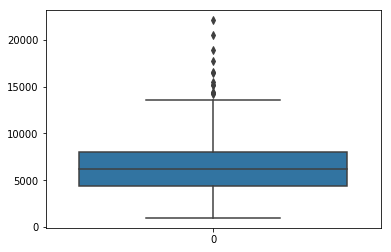

In [8]:
sns.boxplot(data=series)

In [9]:
def outlier_updater(series, cut_off):
    # calculate summary statistics
    data_mean, data_std = np.mean(series), np.std(series)
    # identify outliers
    cut_off = data_std * cut_off
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # calculate interquartile range
    q25, q75 = np.percentile(series, 25), np.percentile(series, 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # identify outliers
    for index, value in series.iteritems(): 
        if value < lower or value > upper:
            series.loc[index] = 0
            # print("Index : {}, Value : {}".format(index, value))

In [10]:
if outlier_tweaker == "Yes":
    outlier_updater(series, 3)

In [11]:
series.replace(0, np.nan, inplace=True)

In [12]:
series.isna().sum()

0

In [13]:
# fill in missing values if we can
if series.isna().sum() > 0:
    series = series.interpolate(method='time') # time or linear

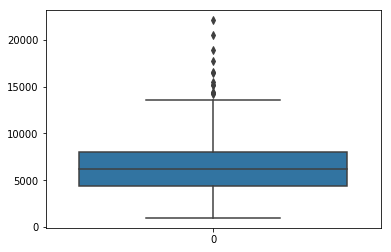

In [14]:
sns.boxplot(data=series)

In [15]:
ts = series

# Checking for stationarity

## Plot the time-series

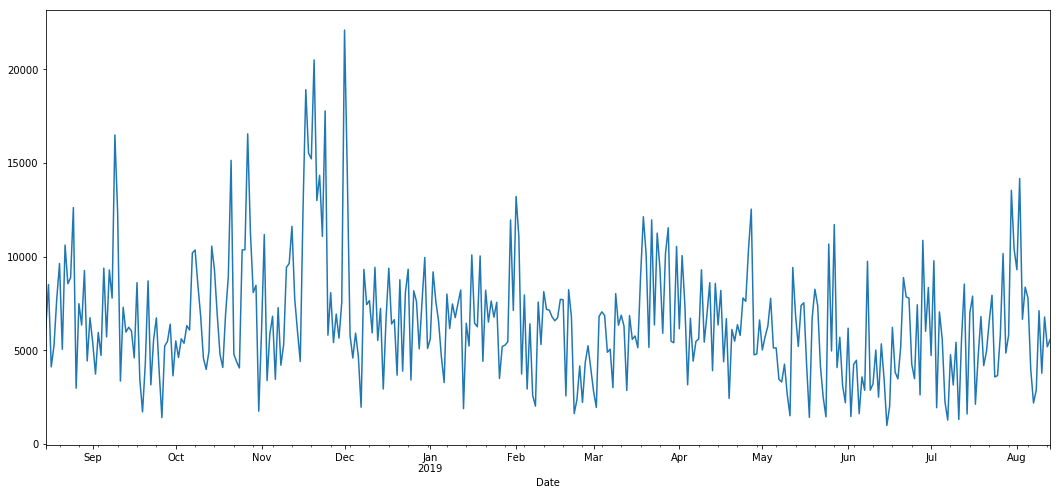

In [16]:
fig = plt.figure(figsize=(18,8))
ts.plot()
plt.show()

## Check Autocorrelation

In [17]:
test_ts = ts.reset_index(drop=True)

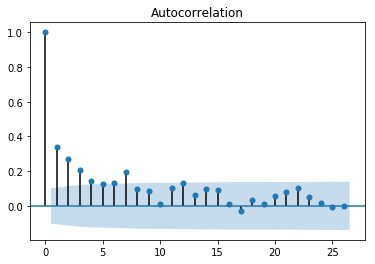

In [18]:
plot_acf(test_ts)
plt.show()

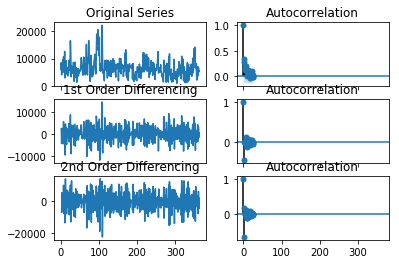

In [19]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(test_ts); axes[0, 0].set_title('Original Series')
plot_acf(test_ts, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(test_ts.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(test_ts.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(test_ts.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(test_ts.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## Function for Testing Stationarity

In [20]:
def test_stationarity(timeseries):
    
    # set figure size
    fig = plt.figure(figsize=(18,8))
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window=7).mean() 
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## Function for Possible ARIMA Model Parameters

In [21]:
from pmdarima.arima.utils import ndiffs

def test_arima(timeseries):
    Adf_Test = ndiffs(timeseries, test='adf')  
    KPSS_Test = ndiffs(timeseries, test='kpss')  
    PP_Test = ndiffs(timeseries, test='pp')  

    print(Adf_Test, KPSS_Test, PP_Test) 

----

## Checking Raw Data

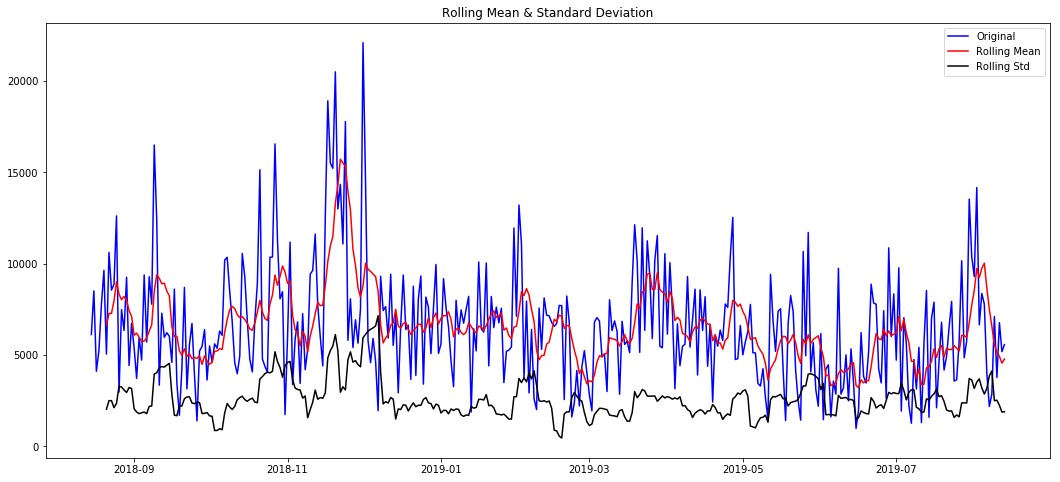

Results of Dickey-Fuller Test:
Test Statistic                  -4.625906
p-value                          0.000116
#Lags Used                       6.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64
0 1 0


In [22]:
test_stationarity(ts)
test_arima(ts)

# Making Time Series Stationary


## Estimating & Eliminating Trend

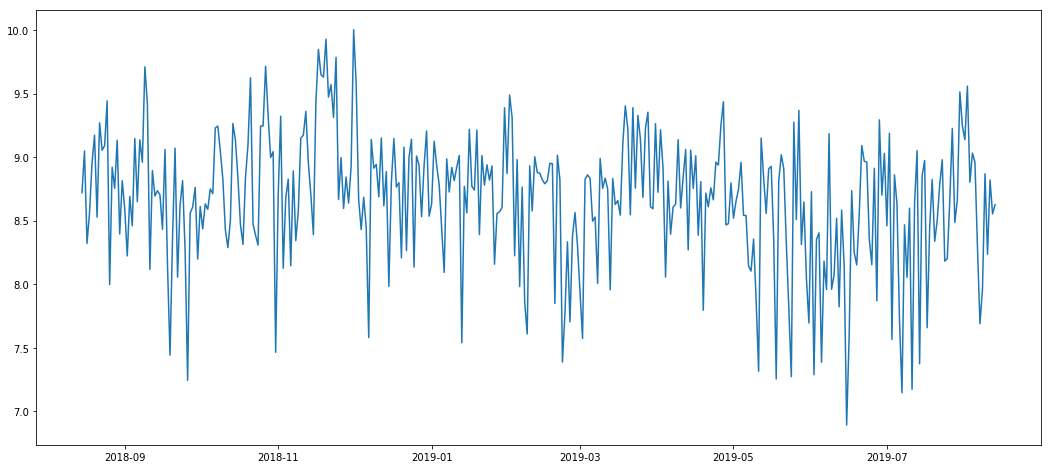

In [23]:
fig = plt.figure(figsize=(18,8))
ts_log = np.log(ts)
plt.plot(ts_log)

## Smoothing:

### Moving average

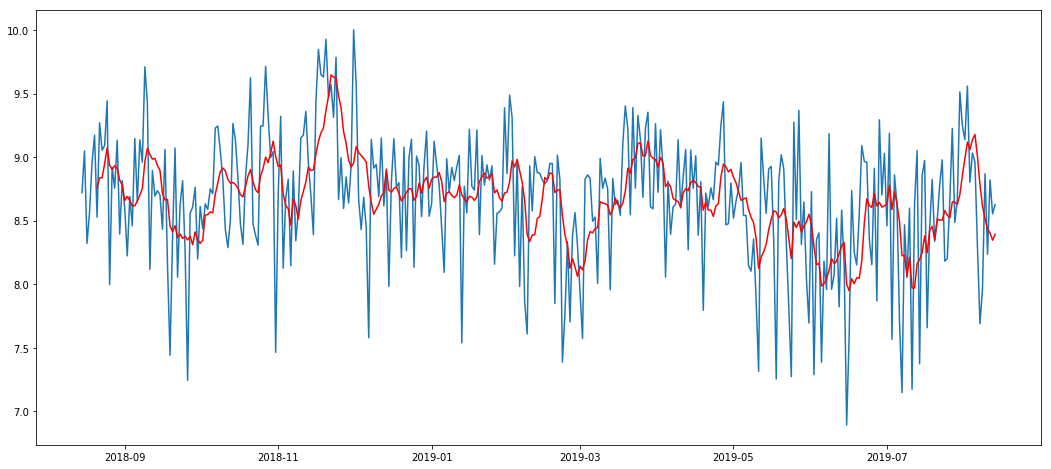

In [24]:
fig = plt.figure(figsize=(18,8))
moving_avg = ts_log.rolling(window=7).mean() 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [25]:
# export results
ts_log.to_csv(data_directory+datapoint+'_ts_log.csv')

In [26]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Date
2018-08-15         NaN
2018-08-16         NaN
2018-08-17         NaN
2018-08-18         NaN
2018-08-19         NaN
2018-08-20         NaN
2018-08-21   -0.231070
2018-08-22    0.432767
2018-08-23    0.216176
2018-08-24    0.142951
2018-08-25    0.369170
2018-08-26   -0.939554
Name: Steps, dtype: float64

In [27]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Date
2018-08-21   -0.231070
2018-08-22    0.432767
2018-08-23    0.216176
2018-08-24    0.142951
2018-08-25    0.369170
Name: Steps, dtype: float64

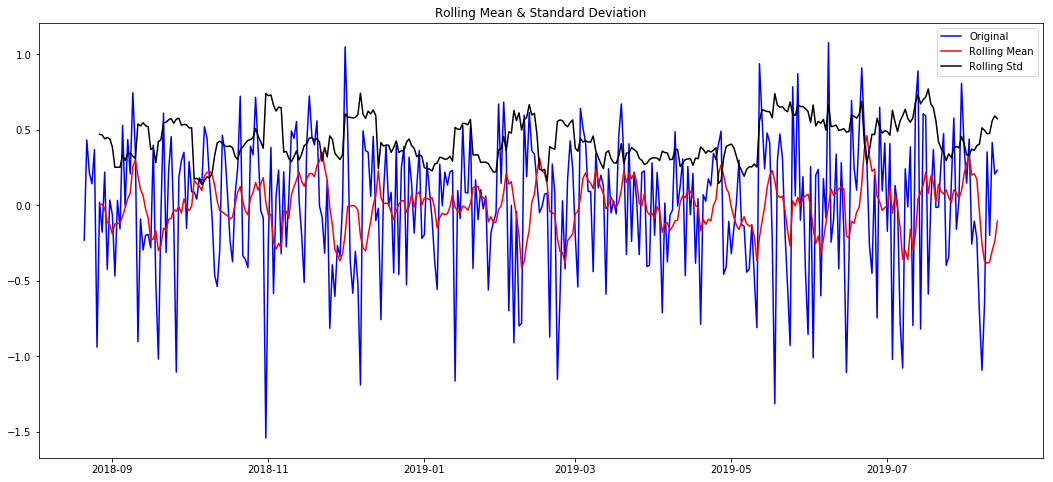

Results of Dickey-Fuller Test:
Test Statistic                -8.304619e+00
p-value                        3.934135e-13
#Lags Used                     9.000000e+00
Number of Observations Used    3.480000e+02
Critical Value (1%)           -3.449282e+00
Critical Value (5%)           -2.869881e+00
Critical Value (10%)          -2.571214e+00
dtype: float64
0 1 0


In [28]:
test_stationarity(ts_log_moving_avg_diff)
test_arima(ts)

### Exponentially Weighted Moving Average

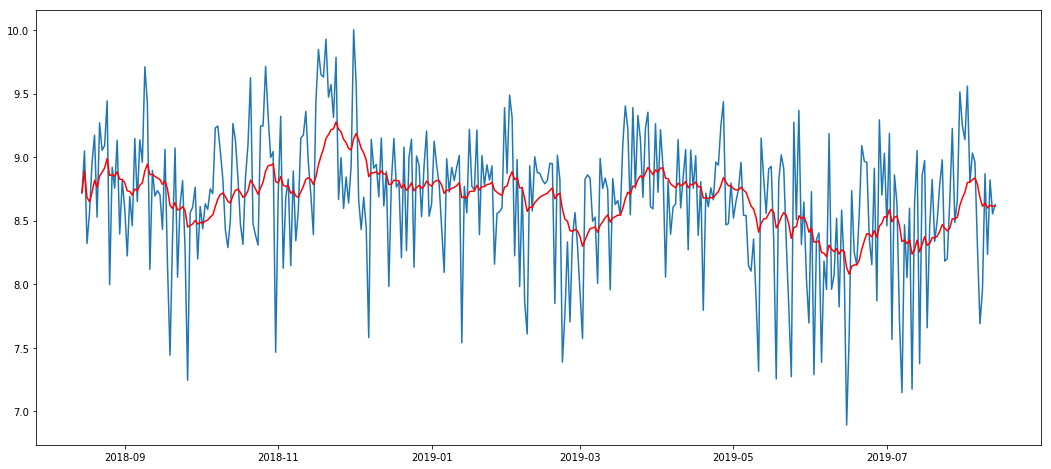

In [29]:
fig = plt.figure(figsize=(18,8))
expwighted_avg = ts_log.ewm(halflife=7).mean()

plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

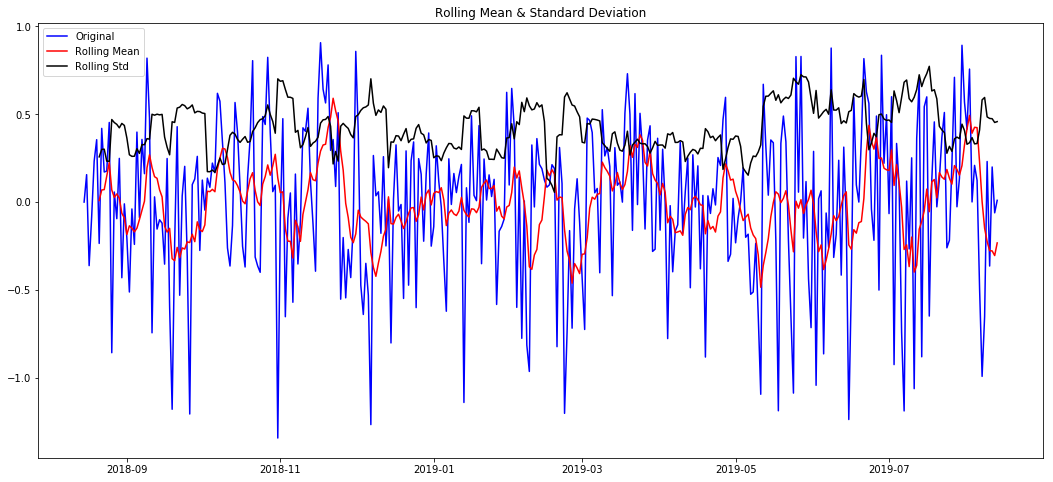

Results of Dickey-Fuller Test:
Test Statistic                -1.712783e+01
p-value                        7.183413e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.630000e+02
Critical Value (1%)           -3.448494e+00
Critical Value (5%)           -2.869535e+00
Critical Value (10%)          -2.571029e+00
dtype: float64
0 1 0


In [30]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)
test_arima(ts)

## Eliminating Trend and Seasonality

### Differencing:

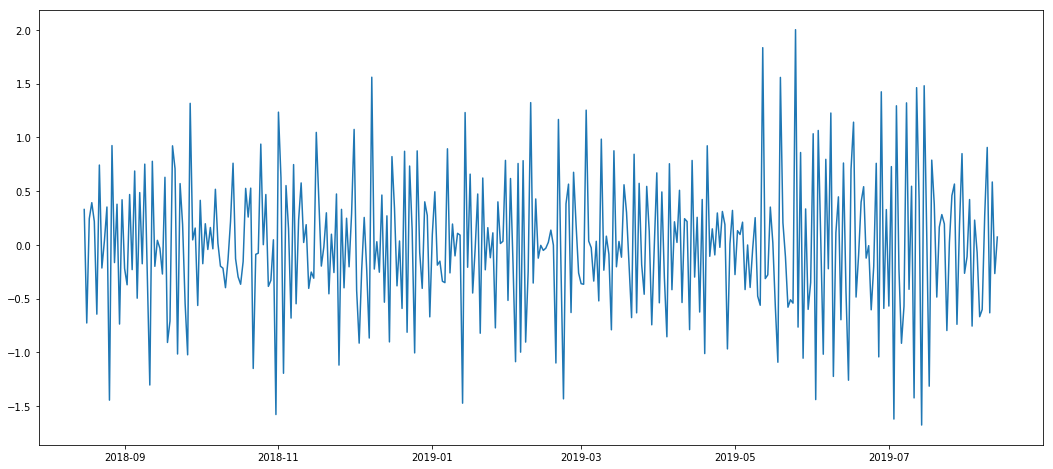

In [31]:
fig = plt.figure(figsize=(18,8))

#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

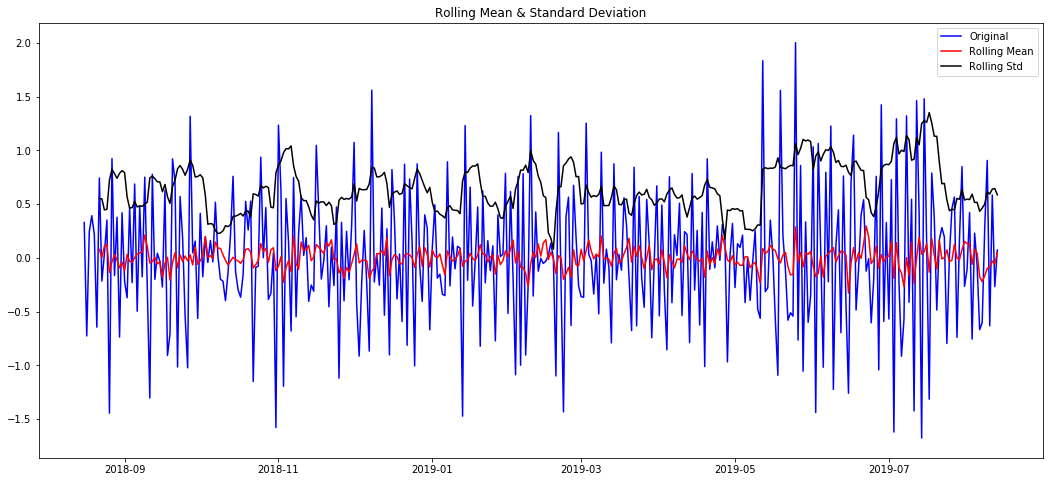

Results of Dickey-Fuller Test:
Test Statistic                -9.059648e+00
p-value                        4.600001e-15
#Lags Used                     1.000000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64
0 1 0


In [32]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)
test_arima(ts)

In [33]:
# export results
ts_log_diff.to_csv(data_directory+datapoint+'_ts_log_diff.csv')

### Decomposition:

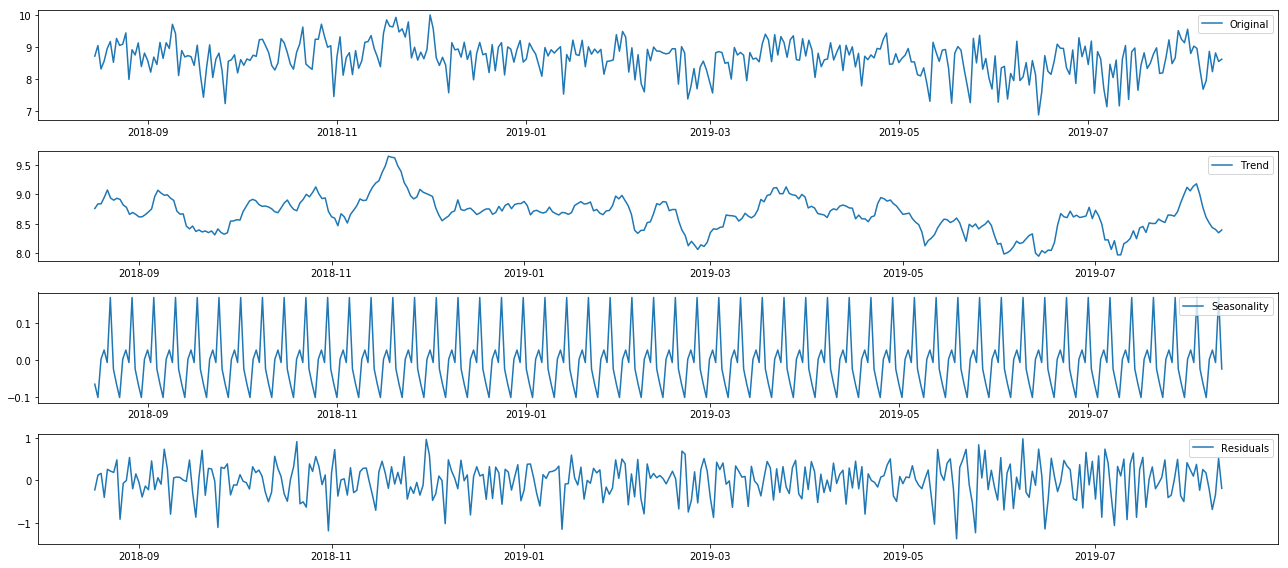

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(18,8))

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

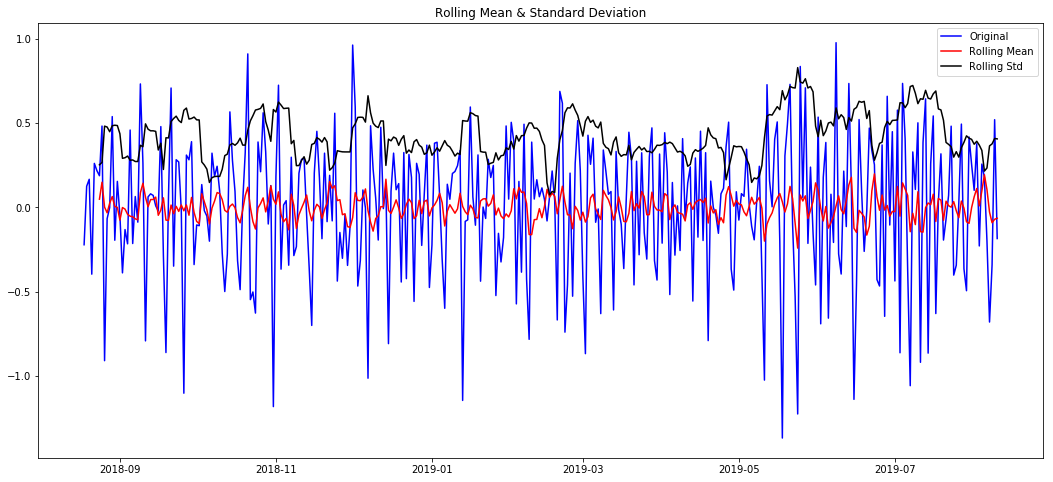

Results of Dickey-Fuller Test:
Test Statistic                -9.933128e+00
p-value                        2.788640e-17
#Lags Used                     1.300000e+01
Number of Observations Used    3.440000e+02
Critical Value (1%)           -3.449503e+00
Critical Value (5%)           -2.869979e+00
Critical Value (10%)          -2.571266e+00
dtype: float64
0 1 0


In [35]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)
test_arima(ts)

In [36]:
# export results
ts_log_decompose.to_csv(data_directory+datapoint+'_ts_log_decompose.csv')